In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import PandasTools
import ast

from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG, display
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
from ipywidgets import interact, widgets
from rdkit.Chem import rdMolDescriptors

 # add project root to path for importing project modules
import sys
sys.path.append('../')
from src.utils.mol_utils import get_inchi_noStereo_from_smi, get_inchi_noStereo_from_mol

[13:51:47] Initializing Normalizer


# functions

In [3]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem

tqdm.pandas()

def get_rooted_fpBV_from_mol(mol,atom,radius=5, nBits=2048,useFeatures=False):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits, fromAtoms=[atom],useFeatures=useFeatures)

def get_rooted_fpBV_from_smi(smi,atom,radius=5, nBits=2048,useFeatures=False):
    mol = Chem.MolFromSmiles(smi)
    return get_rooted_fpBV_from_mol(mol,atom,radius, nBits,useFeatures)

In [4]:
# Function to convert RDKit ExplicitBitVect to a string representation
def convert_bitvect_to_string(bitvect):
    """
    Converts an RDKit ExplicitBitVect to a string representation.
    
    Parameters:
    -----------
    bitvect : rdkit.DataStructs.cDataStructs.ExplicitBitVect
        The bit vector to convert
        
    Returns:
    --------
    str
        A string representation of the bit vector
    """
    if bitvect is None:
        return ""
    
    # Convert to a binary string (0s and 1s)
    bits = []
    for i in range(bitvect.GetNumBits()):
        if bitvect.GetBit(i):
            bits.append('1')
        else:
            bits.append('0')
    
    return ''.join(bits)

In [5]:
def analyze_rooted_fingerprints(atoms_df, radius=2):
    """
    Analyze rooted fingerprints for atom environments with specified radius.
    
    Parameters:
    -----------
    atoms_df : pandas.DataFrame
        DataFrame containing atom information with columns 'preprocessed_smi', 'atom_idx', 'som_label', 'mol_id'
    radius : int, default=2
        Radius for Morgan fingerprint generation
        
    Returns:
    --------
    tuple
        (fingerprint_stats, mols_list, bit_info_list, som_label_counts)
    """
    # Generate rooted fingerprints with specified radius
    # Check if 'mol' column exists in the dataframe
    if 'mol' in atoms_df.columns:
        atoms_df[f'rooted{radius}_2048_bv'] = atoms_df.apply(
            lambda row: get_rooted_fpBV_from_mol(row['mol'], row['atom_idx'], radius=radius), axis=1)
    # Otherwise use preprocessed_smi if it exists
    elif 'preprocessed_smi' in atoms_df.columns:
        atoms_df[f'rooted{radius}_2048_bv'] = atoms_df.apply(
            lambda row: get_rooted_fpBV_from_smi(row['preprocessed_smi'], row['atom_idx'], radius=radius), axis=1)
    else:
        raise ValueError("Neither 'mol' nor 'preprocessed_smi' columns found in the dataframe")

    # Convert fingerprints to string representation
    atoms_df[f'rooted{radius}_2048_str'] = atoms_df[f'rooted{radius}_2048_bv'].apply(convert_bitvect_to_string)

    # Group by fingerprint and analyze SOM label distribution
    rooted_grouped = atoms_df.groupby(f'rooted{radius}_2048_str')
    rooted_stats = rooted_grouped.agg({
        'som_label': ['count', 'mean', 'std', list],
        'preprocessed_smi': lambda x: x.iloc[0],  # Get the first SMILES string for each fingerprint 
        'mol_id': list,  # Get the list mol_id for each fingerprint
        'atom_idx': [lambda x: x.iloc[0],list],  # Get the first atom index for each fingerprint
        f'rooted{radius}_2048_bv': lambda x: x.iloc[0]  # Get the first fingerprint bit vector  
    })

    rooted_stats.sort_values(('som_label', 'count'), ascending=False,inplace=True) 
    print(f"Number of unique radius-{radius} fingerprints: {len(rooted_grouped)}")
    # print(rooted_stats.head(10))


    # Count how many fingerprints appear only once
    single_occurrence = rooted_grouped.size()[rooted_grouped.size() == 1].count()
    print(f"Number of fingerprints that appear only once: {single_occurrence}")
    print(f"Percentage of fingerprints that appear only once: {single_occurrence/len(rooted_grouped)*100:.2f}%")

    # Distribution of SOM labels by fingerprint frequency
    rooted_counts = rooted_grouped.size().reset_index(name='frequency')
    rooted_counts['frequency_bin'] = pd.cut(rooted_counts['frequency'], 
                                           bins=[0, 1, 5, 10, 50, 100, float('inf')],
                                           labels=['1', '2-5', '6-10', '11-50', '51-100', '>100'])

    print("\nDistribution of fingerprints by frequency:")
    print(rooted_counts['frequency_bin'].value_counts().sort_index())

    # Get the values of preprocessed_smi from rooted_stats
    preprocessed_smiles = rooted_stats[('preprocessed_smi', '<lambda>')].values
    # Extract atom indices from rooted_stats
    atom_indices = rooted_stats['atom_idx', '<lambda_0>'].values

    # Convert SMILES to molecules
    mols_list = []
    for smiles in preprocessed_smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                mols_list.append(mol)
            else:
                print(f"Failed to convert SMILES to mol: {smiles}")
        except Exception as e:
            print(f"Error converting SMILES to mol: {smiles}, Error: {str(e)}")

    # Generate fingerprints and bit info
    radius_fingerprints = []
    radius_bit_info_list = []
    for mol, atom_idx in zip(mols_list, atom_indices):
        bi = {}
        fp_atom = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=2048, 
                                                                fromAtoms=[int(atom_idx)], 
                                                                useFeatures=False, bitInfo=bi) # import to use fromAtoms! mapping to molecule's fingperrint can get wrong atom env due to bit collision
        radius_fingerprints.append(fp_atom)
        radius_bit_info_list.append(bi)

    print(f"Successfully converted {len(mols_list)} out of {len(preprocessed_smiles)} SMILES to mol objects")

    radius_all_on_bits = []
    for fp, bit_info in zip(radius_fingerprints, radius_bit_info_list):
        on_bits = list(fp.GetOnBits())
        for bit in on_bits:
            # Check if any atom environment for this bit has the specified radius
            bit_envs = bit_info.get(bit, [])
            if any(rad == radius for atom_idx, rad in bit_envs):
                radius_all_on_bits.append(bit)

    print(f"Duplicated molecules and bit info. New lengths: mols_list={len(mols_list)}, bit_info_list={len(radius_bit_info_list)}")

    # Create tuples of (molecule, fingerprint, bit information)
    radius_tpls = [(mol, x, bi) for mol, x, bi in zip(mols_list, radius_all_on_bits, radius_bit_info_list)]

    som_label_counts = list(rooted_stats[('som_label', 'count')].values)
    
    return rooted_stats, mols_list, radius_tpls, som_label_counts

In [6]:
def analyze_som_label_counts_distribution(rooted_stats, som_label_counts=None):
    """
    Analyze the distribution of SOM labels in the rooted statistics dataframe.
    
    Parameters:
    -----------
    rooted_stats : pandas.DataFrame
        DataFrame containing the rooted statistics with som_label counts
    som_label_counts : list, optional
        List of counts for each SOM label if already extracted
        
    Returns:
    --------
    dict
        Dictionary containing various statistics about the SOM label distribution
    """
    if som_label_counts is None:
        if ('som_label', 'count') in rooted_stats.columns:
            som_label_counts = list(rooted_stats[('som_label', 'count')].values)
        else:
            raise ValueError("som_label counts not found in rooted_stats and not provided separately")
    
    # Basic statistics
    total_count = len(som_label_counts)
    total_atoms = sum(som_label_counts)
    
    # Calculate distribution metrics
    unique_counts = set(som_label_counts)
    count_frequency = {count: som_label_counts.count(count) for count in unique_counts}
    
    # Sort by frequency for better visualization
    sorted_counts = sorted(count_frequency.items(), key=lambda x: x[0])
    
    # Calculate percentiles
    percentiles = {
        '25th': np.percentile(som_label_counts, 25),
        '50th (median)': np.percentile(som_label_counts, 50),
        '75th': np.percentile(som_label_counts, 75),
        '90th': np.percentile(som_label_counts, 90),
        '95th': np.percentile(som_label_counts, 95),
        '99th': np.percentile(som_label_counts, 99)
    }
    
    # Calculate proportion of fingerprints with different count ranges
    count_ranges = {
        '1': sum(1 for c in som_label_counts if c == 1),
        '2-5': sum(1 for c in som_label_counts if 2 <= c <= 5),
        '6-10': sum(1 for c in som_label_counts if 6 <= c <= 10),
        '11-20': sum(1 for c in som_label_counts if 11 <= c <= 20),
        '21-50': sum(1 for c in som_label_counts if 21 <= c <= 50),
        '51-100': sum(1 for c in som_label_counts if 51 <= c <= 100),
        '>100': sum(1 for c in som_label_counts if c > 100)
    }
    
    count_range_proportions = {k: v/total_count for k, v in count_ranges.items()}
    
    # Prepare results
    results = {
        'total_fingerprints': total_count,
        'total_atom_environments': total_atoms,
        'min_count': min(som_label_counts),
        'max_count': max(som_label_counts),
        'mean_count': np.mean(som_label_counts),
        'median_count': np.median(som_label_counts),
        'std_count': np.std(som_label_counts),
        'percentiles': percentiles,
        'count_ranges': count_ranges,
        'count_range_proportions': count_range_proportions,
        'count_frequency': dict(sorted_counts)
    }
    
    # Print summary
    print(f"SOM Label Distribution Analysis:")
    print(f"Total unique fingerprints: {total_count}")
    print(f"Total atom environments: {total_atoms}")
    print(f"Min count: {results['min_count']}, Max count: {results['max_count']}")
    print(f"Mean count: {results['mean_count']:.2f}, Median count: {results['median_count']}")
    print(f"Standard deviation: {results['std_count']:.2f}")
    
    print("\nPercentiles:")
    for p, v in percentiles.items():
        print(f"  {p}: {v}")
    
    print("\nCount range distribution:")
    for k, v in count_ranges.items():
        print(f"  {k}: {v} fingerprints ({count_range_proportions[k]*100:.2f}%)")
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Histogram of counts
    plt.subplot(1, 2, 1)
    plt.hist(som_label_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of SOM Label Counts')
    plt.xlabel('Count per Fingerprint')
    plt.ylabel('Frequency')
    plt.yscale('log')  # Log scale for better visualization
    
    # Plot 2: Count range proportions
    plt.subplot(1, 2, 2)
    ranges = list(count_range_proportions.keys())
    props = [count_range_proportions[r] for r in ranges]
    plt.bar(ranges, props, color='lightgreen', edgecolor='black')
    plt.title('Proportion of Fingerprints by Count Range')
    plt.xlabel('Count Range')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results


In [7]:
import sys
# Import the enhanced entropy module
sys.path.append('../')
from src.utils.enhanced_entropy import (
    calculate_entropy, 
    calculate_entropy_confidence,
)

# Define a function to analyze the entropy of SOM labels for fingerprints
def analyze_fingerprint_entropy(rooted_stats):
    """
    Analyze the entropy of SOM labels for each fingerprint using enhanced methods.
    
    Parameters:
    -----------
    rooted_stats : DataFrame
        DataFrame containing SOM label lists
        
    Returns:
    --------
    DataFrame
        DataFrame with entropy analysis results
    """
    results = []
    som_label_lists = rooted_stats[('som_label', 'list')].values.tolist()
    for idx, som_labels in enumerate(som_label_lists):
        # Convert to binary list (assuming 1 for positive SOM, 0 for negative)
        binary_list = [int(label) for label in som_labels]
        
        # Calculate various entropy metrics
        basic_entropy = calculate_entropy(binary_list)
        entropy, confidence = calculate_entropy_confidence(binary_list)
        
        results.append({
            'Fingerprint_Index': idx,
            'List_Length': len(binary_list),
            'Basic entropy': basic_entropy,
            'Confidence': confidence,
        })

    # Create a DataFrame to display the results
    return pd.DataFrame(results)

# Define a function to analyze the entropy of SOM labels for fingerprints
def analyze_fingerprint_entropy_with_shared_mols(rooted_stats):
    """
    Analyze the entropy of SOM labels for each fingerprint using enhanced methods.
    
    Parameters:
    -----------
    rooted_stats : DataFrame
        DataFrame containing SOM label lists
        
    Returns:
    --------
    DataFrame
        DataFrame with entropy analysis results
    """
    results = []
    som_label_lists = rooted_stats[('som_label', 'list')].values.tolist()
    mol_id_lists = rooted_stats['mol_id sharedMetID'].values.tolist()
    
    for idx, (som_labels, mol_ids) in enumerate(zip(som_label_lists, mol_id_lists)):
        # Convert to binary list (assuming 1 for positive SOM, 0 for negative)
        binary_list = [int(label) for label in som_labels]
        
        # Calculate various entropy metrics
        basic_entropy = calculate_entropy(binary_list)
        entropy, confidence = calculate_entropy_confidence(binary_list)
        
        results.append({
            'Fingerprint_Index': idx,
            'List_Length': len(binary_list),
            'shared_count': len(mol_ids),
            'Basic entropy': basic_entropy,
            'Confidence': confidence,
        })

    # Create a DataFrame to display the results
    return pd.DataFrame(results)


# load data

In [8]:
az_public_share_df = pd.read_csv('../data/az_shared_MetID/120_compounds_with_SoM_annotations.csv')
print(len(az_public_share_df))

az_public_share_df = az_public_share_df[az_public_share_df.Comment.isin(['mol has at least one exact SoM','mol is metabolically stable in the specific experimental setting'])]
print(len(az_public_share_df))

az_public_share_df = az_public_share_df.rename(columns={
    'Compound ID': 'mol_id',
    'SMILES': 'preprocessed_smi',
    'SoMs grouped (numbers provided are atom indices)': 'soms',
    'Exact SoM annotation (1) or extended SoM annotation (0) per group': 'certain'
})

az_public_share_df['inchi_noStereo'] = az_public_share_df['preprocessed_smi'].map(get_inchi_noStereo_from_smi)
az_public_share_df.drop_duplicates(subset=['inchi_noStereo'],inplace=True)
len(az_public_share_df)

120
99


98

In [9]:
az_public_share_df['soms'] = az_public_share_df['soms'].map(ast.literal_eval)

In [10]:
atoms_share_descriptors = pd.read_csv('../output/descriptors/az_sharedMetID_annotation_cleaned_id_smi_5_descriptors.csv')
print(len(atoms_share_descriptors))

2995


In [11]:
atoms_share_descriptors = atoms_share_descriptors.drop(columns=['som_label'])
atoms_share_descriptors.columns

Index(['mol_id', 'atom_idx', 'AtomType_C.3_0', 'AtomType_C.2_0',
       'AtomType_C.1_0', 'AtomType_C.ar_0', 'AtomType_N.3_0', 'AtomType_N.2_0',
       'AtomType_N.1_0', 'AtomType_N.ar_0',
       ...
       'InductiveEffect_F_5', 'InductiveEffect_Si_5', 'InductiveEffect_Cl_5',
       'InductiveEffect_Br_5', 'InductiveEffect_I_5', 'InductiveEffect_B_5',
       'longestMaxTopDistinMolecule', 'highestMaxTopDistinMatrixRow',
       'diffSPAN', 'refSPAN'],
      dtype='object', length=1590)

In [12]:
atoms_share_descriptors.head()

,mol_id,atom_idx,AtomType_C.3_0,AtomType_C.2_0,AtomType_C.1_0,AtomType_C.ar_0,AtomType_N.3_0,AtomType_N.2_0,AtomType_N.1_0,AtomType_N.ar_0,...,InductiveEffect_F_5,InductiveEffect_Si_5,InductiveEffect_Cl_5,InductiveEffect_Br_5,InductiveEffect_I_5,InductiveEffect_B_5,longestMaxTopDistinMolecule,highestMaxTopDistinMatrixRow,diffSPAN,refSPAN
0,Cmpd 2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,17.0,14.0,3.0,0.8235
1,Cmpd 2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,17.0,13.0,4.0,0.7647
2,Cmpd 2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,17.0,14.0,3.0,0.8235
3,Cmpd 2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.9907,0.0,0.0,0.0,0.0,0.0,17.0,12.0,5.0,0.7059
4,Cmpd 2,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,17.0,13.0,4.0,0.7647


In [13]:
az_share_atom_all = pd.read_csv('../data/az_shared_MetID/az_sharedMetID_annotation_atoms_all.csv')
az_share_atom_explicit = pd.read_csv('../data/az_shared_MetID/az_sharedMetID_annotation_atoms_explicit.csv')
len(az_share_atom_all),len(az_share_atom_explicit)

(2700, 2321)

In [14]:
# get two atom sets with descriptors
atoms_explicit_descriptors = pd.merge(az_share_atom_explicit,atoms_share_descriptors,on=['mol_id','atom_idx'],how='inner')
atoms_all_descriptors = pd.merge(az_share_atom_all,atoms_share_descriptors,on=['mol_id','atom_idx'],how='inner')
len(atoms_all_descriptors),len(atoms_explicit_descriptors)

(2700, 2321)

In [15]:
# remove duplicates --> already no duplicates
atoms_all_descriptors_nodup = atoms_all_descriptors.drop_duplicates(subset=atoms_all_descriptors.columns[4:]).copy()
atoms_explicit_descriptors_nodup = atoms_explicit_descriptors.drop_duplicates(subset=atoms_explicit_descriptors.columns[4:]).copy()

print(len(atoms_all_descriptors_nodup))
print(len(atoms_explicit_descriptors_nodup))

2700
2321


In [16]:
print(atoms_all_descriptors_nodup.som_label.value_counts())
print(atoms_explicit_descriptors_nodup.som_label.value_counts())

som_label
0    2119
1     581
Name: count, dtype: int64
som_label
0    2119
1     202
Name: count, dtype: int64


In [17]:
descriptors_columns = atoms_explicit_descriptors_nodup.columns[4:]
len(descriptors_columns)

1588

In [18]:
# Create a dictionary of mol_id as key and mol as value
from rdkit import Chem

# Initialize an empty dictionary to store mol_id and mol pairs
mol_dict = {}

# Iterate through the dataframe to create molecules from SMILES
for idx, row in az_public_share_df.iterrows():
    mol_id = row['mol_id']
    smiles = row['preprocessed_smi']
    mol = Chem.MolFromSmiles(smiles)
    if mol:  # Check if the molecule was successfully created
        mol_dict[mol_id] = mol

print(f"Created dictionary with {len(mol_dict)} molecules")

Created dictionary with 98 molecules


# check and visulize atom environments

Number of unique radius-1 fingerprints: 387
Number of fingerprints that appear only once: 153
Percentage of fingerprints that appear only once: 39.53%

Distribution of fingerprints by frequency:
frequency_bin
1         153
2-5       143
6-10       38
11-50      49
51-100      2
>100        2
Name: count, dtype: int64
Successfully converted 387 out of 387 SMILES to mol objects
Duplicated molecules and bit info. New lengths: mols_list=387, bit_info_list=387


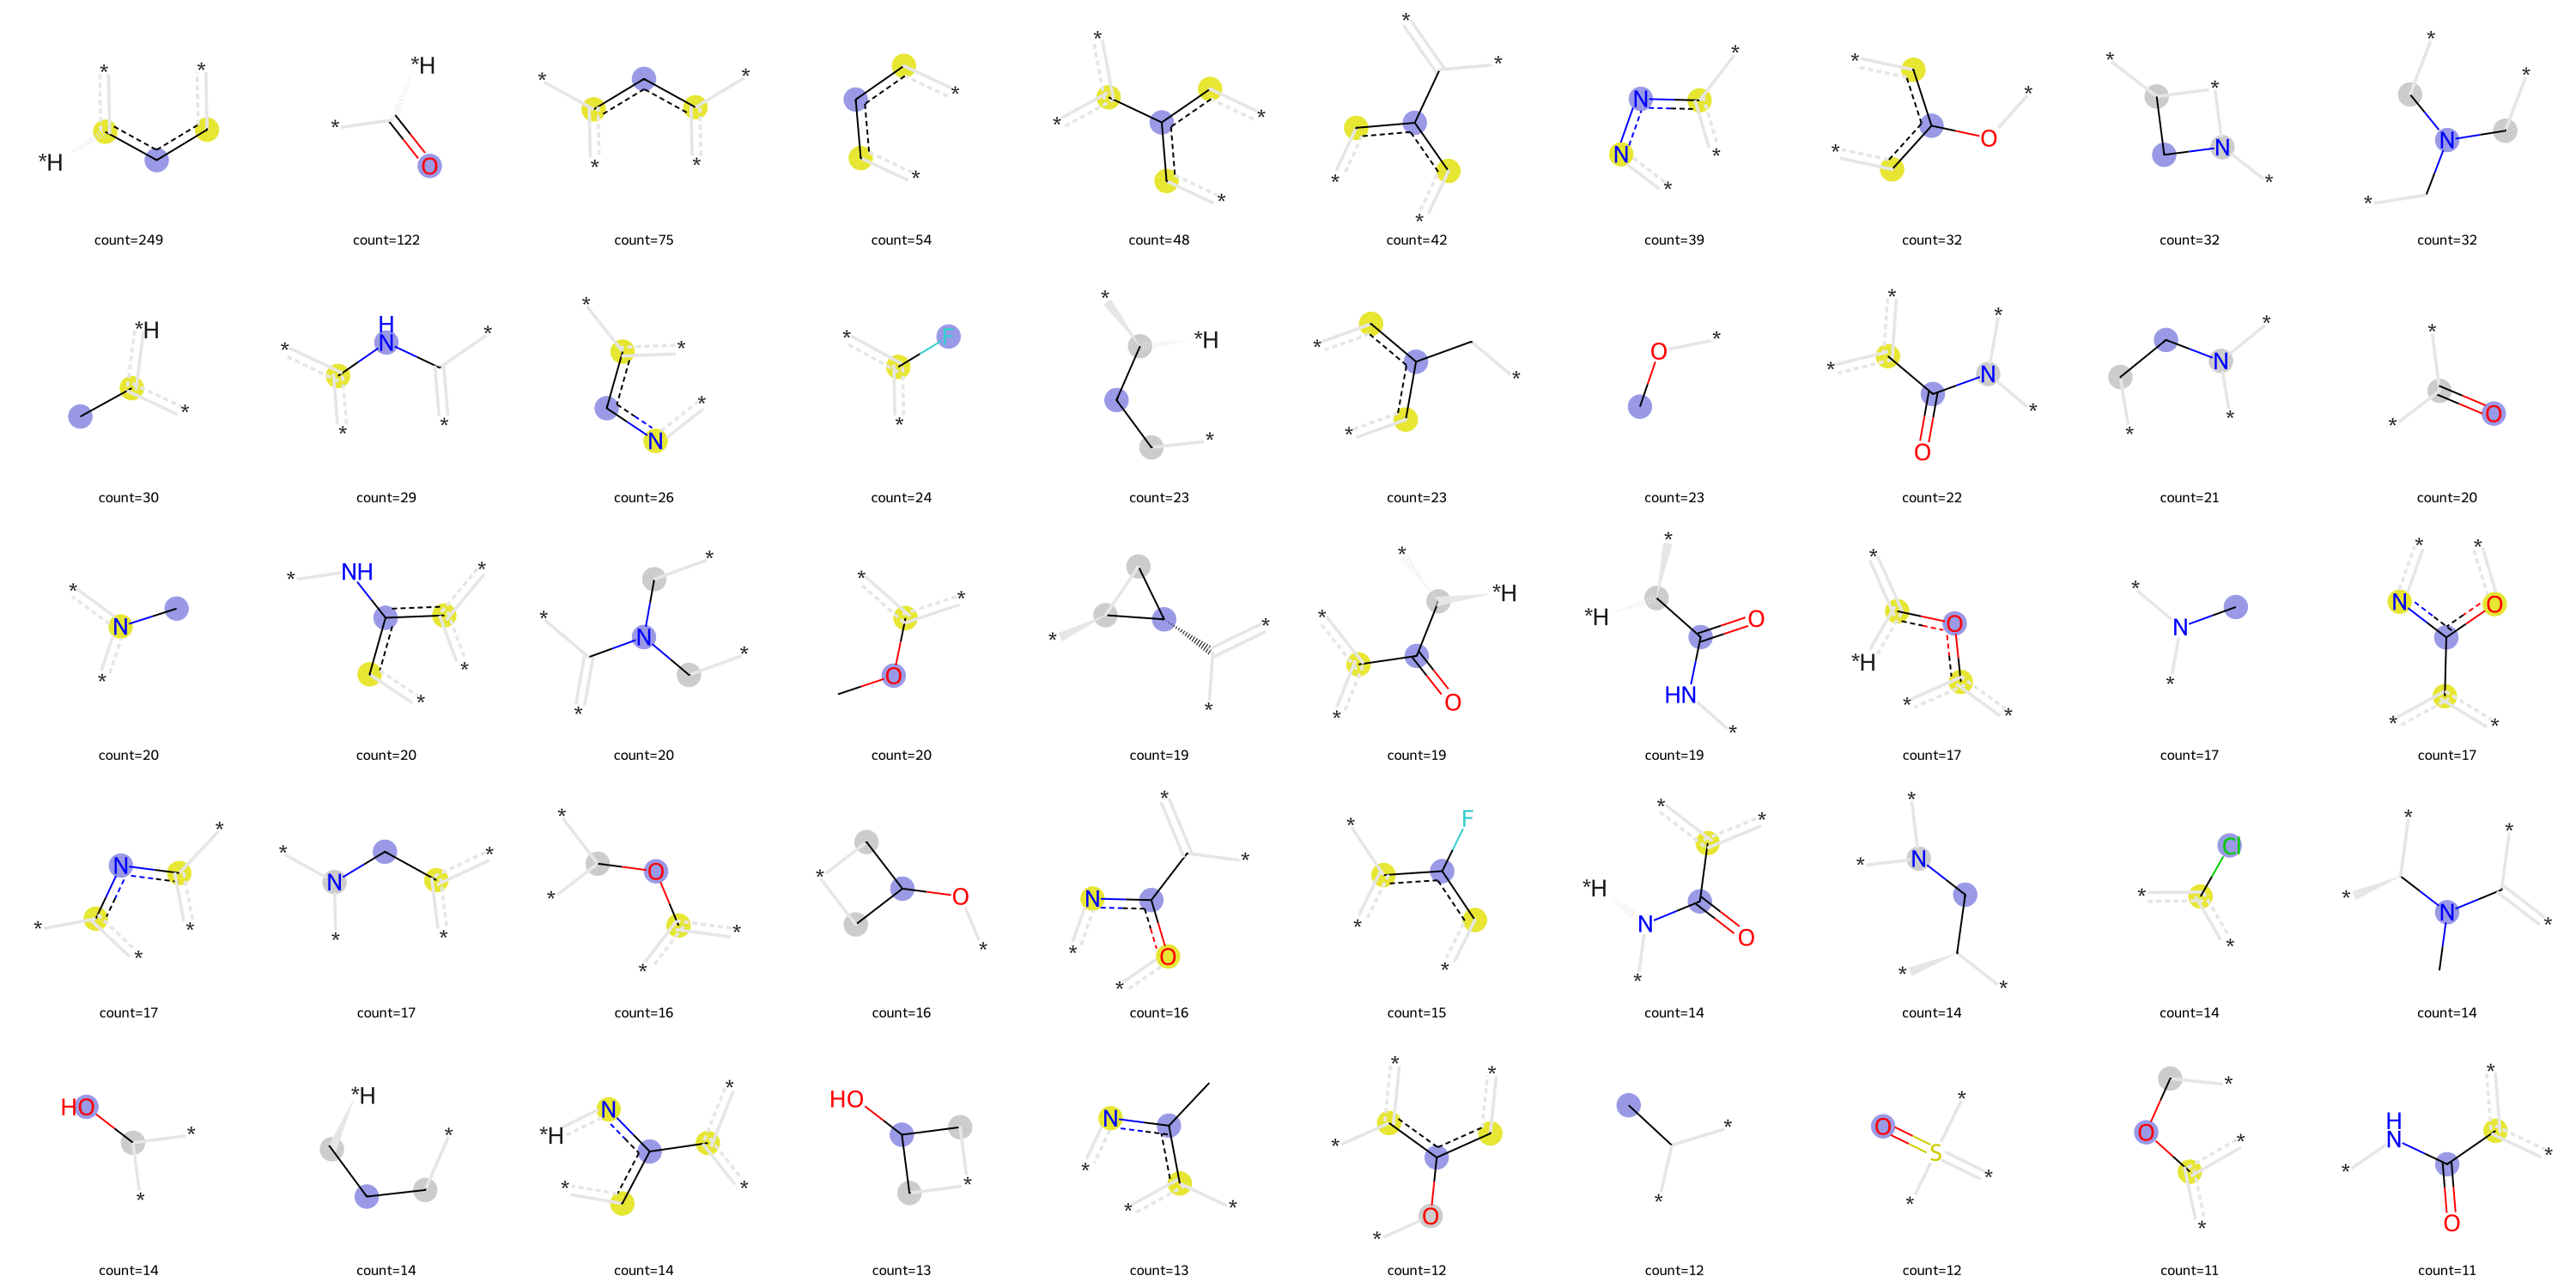

In [19]:
# Analyze fingerprints with radius 1
rooted1_stats, mols_list, radius1_tpls, som_label_counts = analyze_rooted_fingerprints(atoms_explicit_descriptors_nodup, radius=1)

# Get top 50 fingerprint bits
top_50_bits = radius1_tpls[:50]

# Draw top 50 Morgan fingerprint bits with radius 1
display(Draw.DrawMorganBits(top_50_bits, molsPerRow=10,
                           legends=[f"count={som_label_counts[i]}" for i in range(50)],
                           subImgSize=(300,300)))

Number of unique radius-2 fingerprints: 1009
Number of fingerprints that appear only once: 640
Percentage of fingerprints that appear only once: 63.43%

Distribution of fingerprints by frequency:
frequency_bin
1         640
2-5       303
6-10       27
11-50      39
51-100      0
>100        0
Name: count, dtype: int64
Successfully converted 1009 out of 1009 SMILES to mol objects
Duplicated molecules and bit info. New lengths: mols_list=1009, bit_info_list=1009


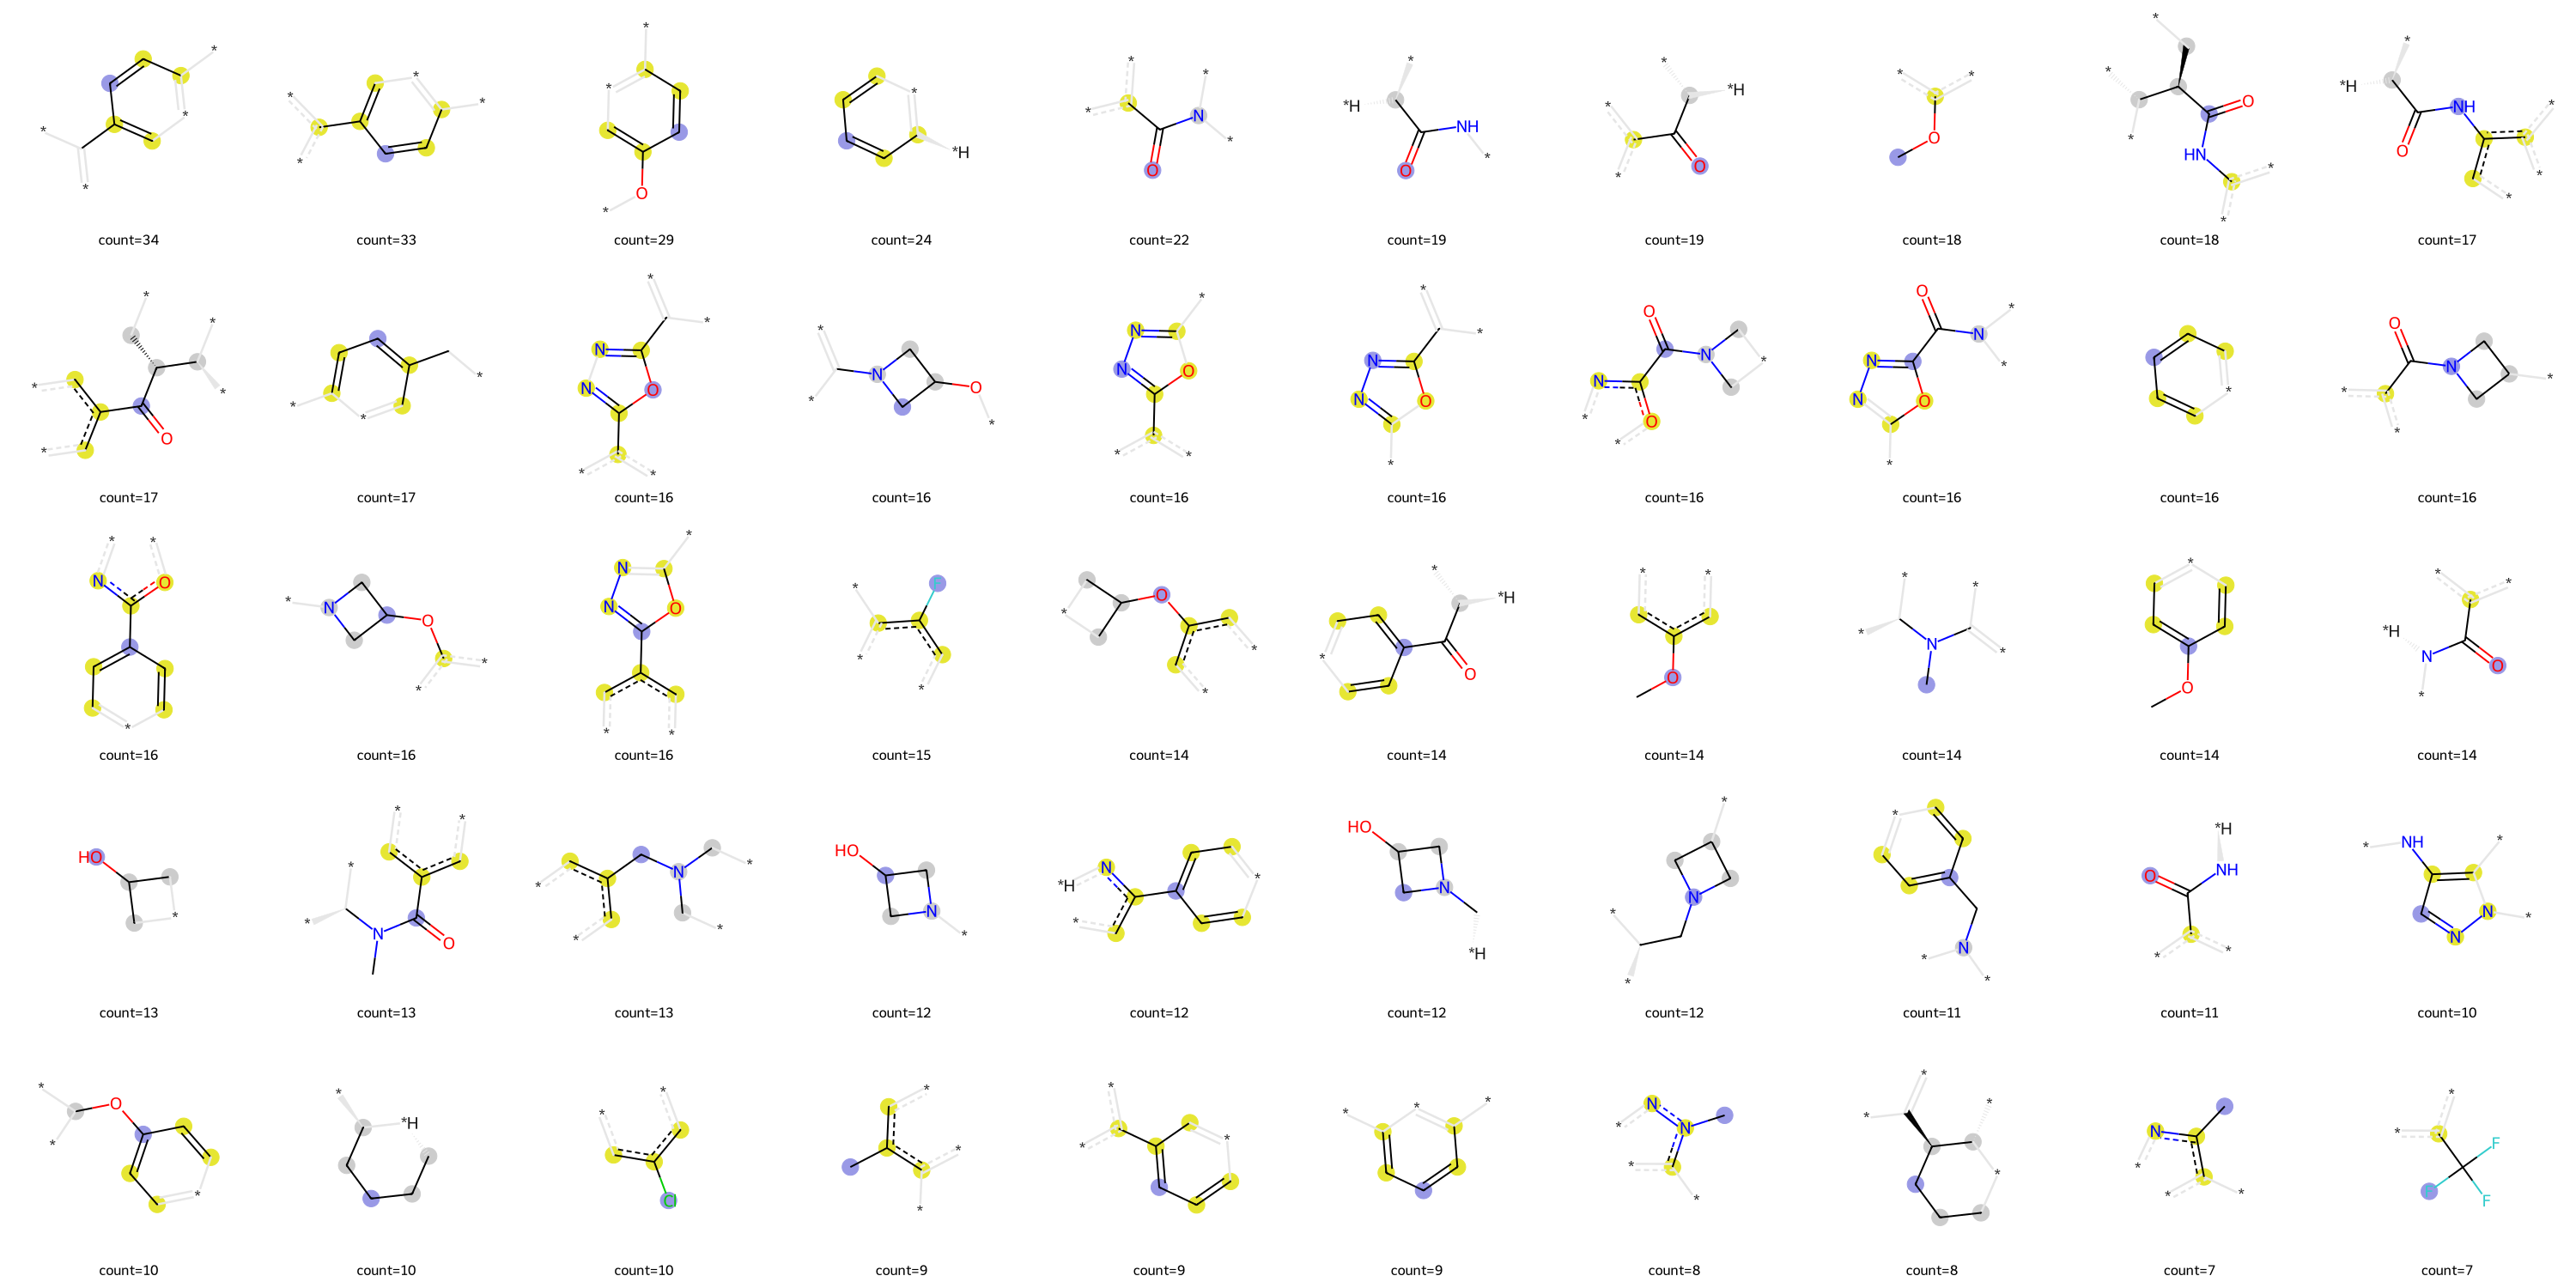

In [20]:
# Analyze fingerprints with radius 2
rooted2_stats, mols_list, radius2_tpls, som_label_counts = analyze_rooted_fingerprints(atoms_explicit_descriptors_nodup, radius=2)

# Get top 50 fingerprint bits
top_50_bits = radius2_tpls[:50]

# Draw top 50 Morgan fingerprint bits with radius 2
display(Draw.DrawMorganBits(top_50_bits, molsPerRow=10,
                           legends=[f"count={som_label_counts[i]}" for i in range(50)],
                           subImgSize=(300,300)))


SOM Label Distribution Analysis:
Total unique fingerprints: 387
Total atom environments: 2321
Min count: 1, Max count: 249
Mean count: 6.00, Median count: 2.0
Standard deviation: 15.88

Percentiles:
  25th: 1.0
  50th (median): 2.0
  75th: 5.0
  90th: 14.0
  95th: 20.0
  99th: 48.83999999999992

Count range distribution:
  1: 153 fingerprints (39.53%)
  2-5: 143 fingerprints (36.95%)
  6-10: 38 fingerprints (9.82%)
  11-20: 34 fingerprints (8.79%)
  21-50: 15 fingerprints (3.88%)
  51-100: 2 fingerprints (0.52%)
  >100: 2 fingerprints (0.52%)


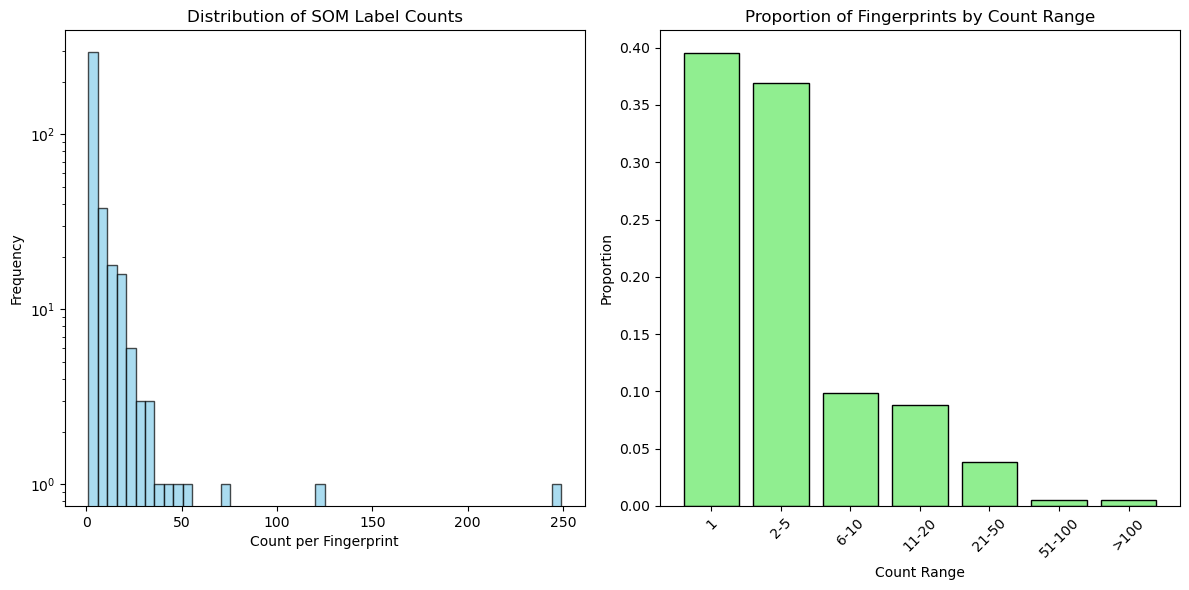

In [21]:
rooted1_stats_dict = analyze_som_label_counts_distribution(rooted1_stats)

SOM Label Distribution Analysis:
Total unique fingerprints: 1009
Total atom environments: 2321
Min count: 1, Max count: 34
Mean count: 2.30, Median count: 1.0
Standard deviation: 3.35

Percentiles:
  25th: 1.0
  50th (median): 1.0
  75th: 2.0
  90th: 5.0
  95th: 7.0
  99th: 17.0

Count range distribution:
  1: 640 fingerprints (63.43%)
  2-5: 303 fingerprints (30.03%)
  6-10: 27 fingerprints (2.68%)
  11-20: 34 fingerprints (3.37%)
  21-50: 5 fingerprints (0.50%)
  51-100: 0 fingerprints (0.00%)
  >100: 0 fingerprints (0.00%)


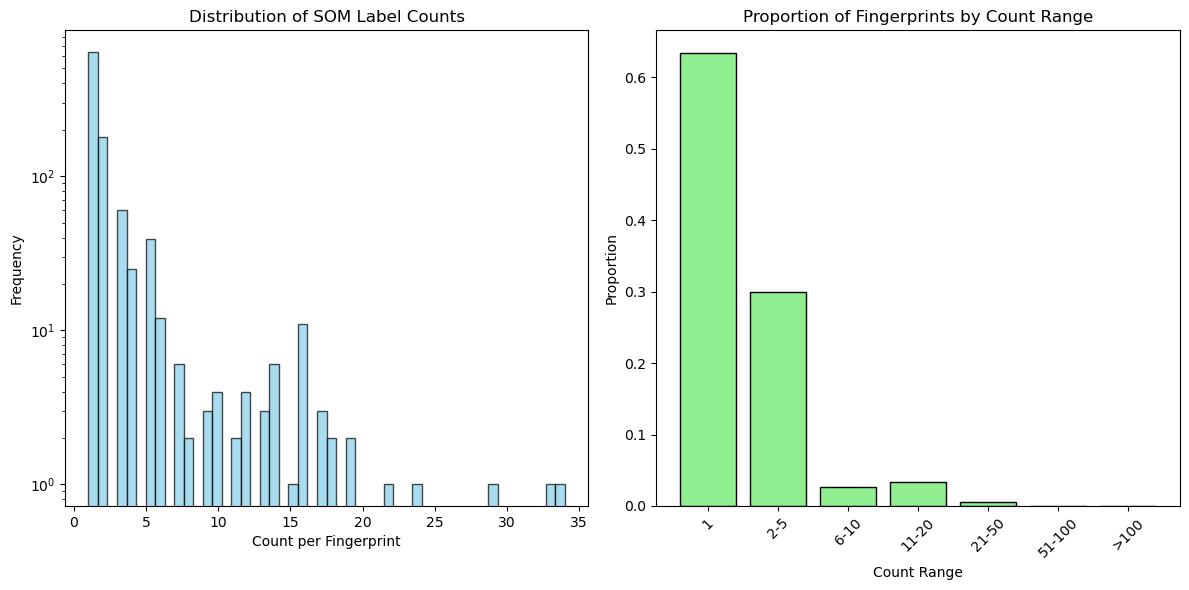

In [22]:
rooted2_stats_dict = analyze_som_label_counts_distribution(rooted2_stats)

,range,percentage
0,1,0.395349
1,2-5,0.369509
2,6-10,0.098191
3,11-20,0.087855
4,21-50,0.038760
5,≥51,0.010336


,range,percentage
0,1,0.634291
1,2-5,0.300297
2,6-10,0.026759
3,11-20,0.033697
4,21-50,0.004955


<Figure size 1200x800 with 0 Axes>

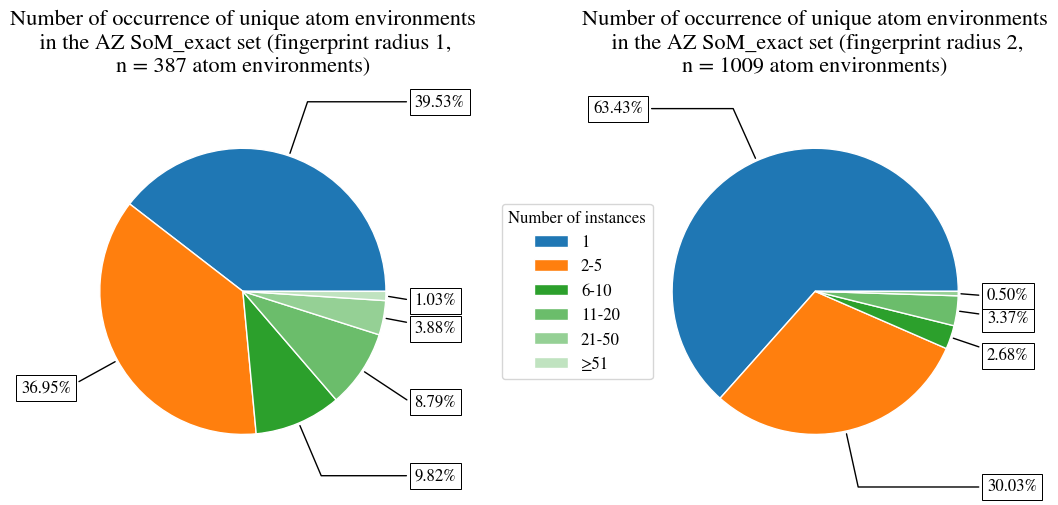

In [23]:
# Create pie charts for radius 1 and 2 only and store the data in dataframes
plt.figure(figsize=(12, 8))  # This controls the overall figure size
# Set font properties for better readability
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'STIXGeneral',
    'font.weight': 'normal',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Function to create range data and pie chart
def create_range_pie_occurrence(stats_dict, title, ax, show_legend=True):
    
    # Define colors - first 3 standard colors, then progressively lighter greens
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # First 3 standard colors
    # Add progressively lighter greens for additional ranges
    green_base = np.array([44/255, 160/255, 44/255])  # RGB for #2ca02c
    max_additional = 4  # Maximum number of additional colors we might need
    # Generate lighter green colors for additional ranges
    lightness_values = 0.3 + 0.6 * np.linspace(0, 1, max_additional)  # Scale from 0.3 to 0.9 to create progressively lighter green colors
    # Create a list of progressively lighter green colors
    new_colors = []
    for l in lightness_values:
        # Mix the base green with white based on lightness factor
        lighter_green = tuple(green_base + (1 - green_base) * l)
        new_colors.append(lighter_green)
        
    # Add these new colors to our color palette
    colors.extend(new_colors)
    
    # Extract count range proportions and combine ranges 51-100 and >100
    def combine_ranges(stats_dict):
        ranges = list(stats_dict['count_range_proportions'].keys())
        props = list(stats_dict['count_range_proportions'].values())
        
        # Create new ranges and props lists
        new_ranges = []
        new_props = []
        
        # Combine ranges that include 51-100 and >100
        combined_prop = 0
        combined_range = "≥51"
        
        for i, r in enumerate(ranges):
            if "51-100" in r or ">100" in r:
                combined_prop += props[i]
            else:
                new_ranges.append(r)
                new_props.append(props[i])
        
        # Add the combined range if it has any values
        if combined_prop > 0:
            new_ranges.append(combined_range)
            new_props.append(combined_prop)
            
        return new_ranges, new_props
    
    labels, proportions = combine_ranges(stats_dict)
    
    # Plot the pie chart
    # The size of the pie is controlled by the size of the axis (ax) it's drawn on
    # The figsize parameter in plt.subplots() below controls this
    wedges, texts = ax.pie(
        proportions, 
        startangle=0, 
        colors=colors,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1},
        # radius=0.8  # This parameter can control the size of the pie within the axis
    )
    
    # Add percentage labels outside the pie chart
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        
        # Use different connection style for small proportions
        if proportions[i] < 0.002:  # less than 0.2%
            connectionstyle = f"angle,angleA=0,angleB={-ang*80}"  # curved connection line but shorter
            # Position the text box closer for very small proportions
            y_text = -15*y
        elif proportions[i] < 0.02:  # less than 3%
            connectionstyle = f"angle,angleA=0,angleB={ang*5}"  # curved connection line but shorter
            # Position the text box closer for very small proportions
            y_text = 2*y
        else:
            connectionstyle = f"angle,angleA=0,angleB={ang}"    
            y_text = 1.4*y
            
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f"{proportions[i]*100:.2f}%", 
                   xy=(x, y), xytext=(1.2*np.sign(x), y_text),
                   horizontalalignment=horizontalalignment, **kw)
    
    # Add legend instead of labels on pie chart
    if show_legend:
        ax.legend(wedges, labels, title="Number of instances", 
                  loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))
    
    ax.set_title(f'Number of occurrence of unique atom environments\n in the AZ SoM_exact set (fingerprint radius {title}', pad=30)
        # Create DataFrame
    df = pd.DataFrame({
        'range': labels,
        'percentage': proportions
    })# Return the labels and proportions for further analysis
    display(df)

# Create subplots with more space between them to avoid overlap
# This figsize parameter controls the overall size of the figure and thus the size of each pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.6})

# Create pie charts and get the data
radius1_entropy_dist = create_range_pie_occurrence(rooted1_stats_dict, f'1,\nn = {len(rooted1_stats)} atom environments)', ax1)
radius2_entropy_dist = create_range_pie_occurrence(rooted2_stats_dict, f'2,\nn = {len(rooted2_stats)} atom environments)', ax2, show_legend=False)

# calculate entropy

In [24]:
# Calculate entropy for each radius
rooted1_entropy_df = analyze_fingerprint_entropy(rooted1_stats)
rooted2_entropy_df = analyze_fingerprint_entropy(rooted2_stats)
# Display top 20 fingerprints with highest combined scores for each radius
print("\nTop 20 fingerprints by combined score for radius=1:")
display(rooted1_entropy_df.sort_values('Basic entropy', ascending=False).head(20))

print("\nTop 20 fingerprints by combined score for radius=2:")
display(rooted2_entropy_df.sort_values('Basic entropy', ascending=False).head(20))



Top 20 fingerprints by combined score for radius=1:


,Fingerprint_Index,List_Length,Basic entropy,Confidence
190,190,2,1.000000,0.585786
226,226,2,1.000000,0.585786
86,86,6,1.000000,0.710102
168,168,2,1.000000,0.585786
203,203,2,1.000000,0.585786
180,180,2,1.000000,0.585786
88,88,6,1.000000,0.710102
89,89,6,1.000000,0.710102
20,20,20,1.000000,0.817256
174,174,2,1.000000,0.585786



Top 20 fingerprints by combined score for radius=2:


,Fingerprint_Index,List_Length,Basic entropy,Confidence
330,330,2,1.000000,0.585786
291,291,2,1.000000,0.585786
215,215,2,1.000000,0.585786
334,334,2,1.000000,0.585786
345,345,2,1.000000,0.585786
207,207,2,1.000000,0.585786
230,230,2,1.000000,0.585786
343,343,2,1.000000,0.585786
236,236,2,1.000000,0.585786
246,246,2,1.000000,0.585786


In [25]:
print(f"Number of fingerprints with multiple occurrences (radius=1): {len(rooted1_entropy_df[rooted1_entropy_df['List_Length'] > 1])}")
print(f"Number of fingerprints with multiple occurrences (radius=2): {len(rooted2_entropy_df[rooted2_entropy_df['List_Length'] > 1])}")

Number of fingerprints with multiple occurrences (radius=1): 234
Number of fingerprints with multiple occurrences (radius=2): 369


In [26]:
rooted2_entropy_df[rooted2_entropy_df['List_Length'] == 1]['Basic entropy'].value_counts()

Basic entropy
0.0    640
Name: count, dtype: int64

Entropy distribution for radius=1:


,range,count,percentage
0,0,192,82.051282
1,"(0, 0.5]",5,2.136752
2,"(0.5, 0.8]",8,3.418803
3,"(0.8, 1.0]",29,12.393162


Radius=2 Basic Entropy Distribution:


,range,count,percentage
0,0,334,90.514905
1,"(0, 0.5]",0,0.000000
2,"(0.5, 0.8]",8,2.168022
3,"(0.8, 1.0]",27,7.317073


<Figure size 1200x800 with 0 Axes>

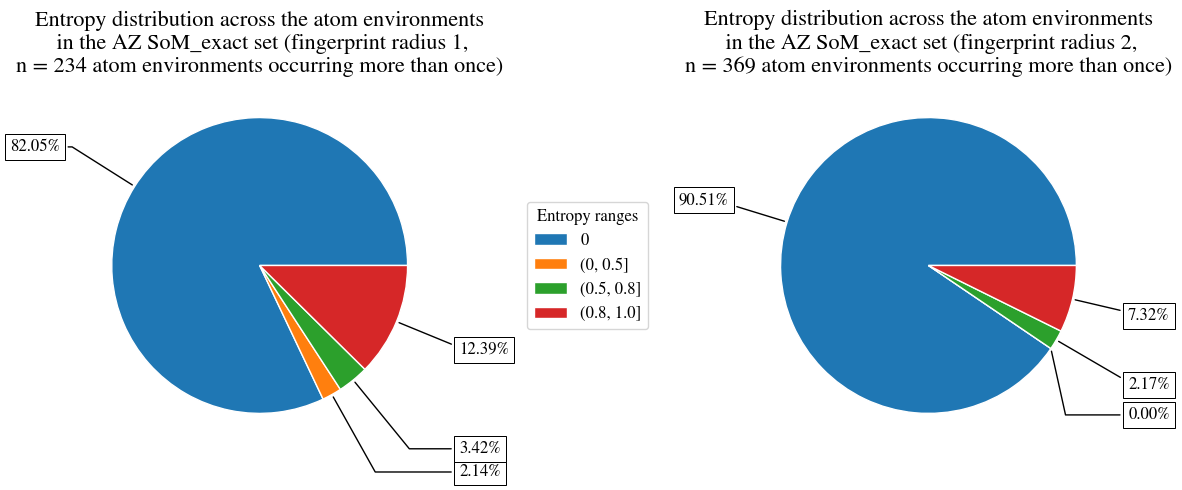

In [27]:
# Create pie charts for radius 1 and 2 only and store the data in dataframes
plt.figure(figsize=(12, 8))
    # Set font properties for better readability
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'STIXGeneral',
    'font.weight': 'normal',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Function to create range data and pie chart
def create_range_pie(data, title, ax, show_legend=True):
    # Define entropy ranges
    labels = ['0', '(0, 0.5]', '(0.5, 0.8]', '(0.8, 1.0]']
    
    # Create a copy of the data to avoid modifying the original
    entropy_values = data.copy()
    
    counts = [len(entropy_values[entropy_values==0]),
              len(entropy_values[(entropy_values>0) & (entropy_values<=0.5)]),
              len(entropy_values[(entropy_values>0.5) & (entropy_values<=0.8)]),
              len(entropy_values[entropy_values>0.8])]
    
    # Count occurrences in each bin
    proportions = [counts[0]/sum(counts),
                  counts[1]/sum(counts),
                  counts[2]/sum(counts),
                  counts[3]/sum(counts)]
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'range': labels,
        'count': counts,
        'percentage': [p * 100 for p in proportions]
    })
    
    # Define colors for the pie chart
    colors = plt.cm.tab10.colors[:4]  # Use default matplotlib colors
    
    # Plot the pie chart
    wedges, texts = ax.pie(
        proportions, 
        startangle=0, 
        colors=colors,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}
    )
    
    # Add percentage labels outside the pie chart
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        
        
        
        # Use different connection style for small proportions
        if proportions[i] < 0.01:  # less than 1%
            # For very small slices (less than 1% of the pie chart)
            # Use a curved connection line with a negative angle to avoid overlapping with other annotations
            connectionstyle = f"angle,angleA=0,angleB={-ang*3}"  # Triple the angle but in opposite direction
            # Position the text box further away from the pie chart
            # Multiplier 1.8 pushes the text outward more than the default positioning
            y_text = 1.8*y
        elif proportions[i] < 0.02:
            connectionstyle = f"angle,angleA=0,angleB={ang}"  # curved connection line
            # Position the text box lower for very small proportions
            y_text = 1.4*y
        elif proportions[i] < 0.05:
            connectionstyle = f"angle,angleA=0,angleB={ang}"  # curved connection line
            # Position the text box lower for very small proportions
            y_text = 1.6*y
        else:
            connectionstyle = f"angle,angleA=0,angleB={ang}"    
            y_text = 1.5*y
            
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f"{proportions[i]*100:.2f}%", 
                   xy=(x, y), xytext=(1.35*np.sign(x), y_text),
                   horizontalalignment=horizontalalignment, **kw)
    
    # Add legend instead of labels on pie chart
    if show_legend:
        ax.legend(wedges, labels, title="Entropy ranges", 
                  loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))
    
    ax.set_title(f'Entropy distribution across the atom environments\n in the AZ SoM_exact set (fingerprint radius {title}')
    return result_df

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create pie charts and get the data
radius1_entropy_dist_freqency2 = create_range_pie(rooted1_entropy_df[rooted1_entropy_df['List_Length'] > 1]['Basic entropy'], f'1,\nn = {len(rooted1_entropy_df[rooted1_entropy_df["List_Length"] > 1])} atom environments occurring more than once)', ax1)
radius2_entropy_dist_freqency2 = create_range_pie(rooted2_entropy_df[rooted2_entropy_df['List_Length'] > 1]['Basic entropy'], f'2,\nn = {len(rooted2_entropy_df[rooted2_entropy_df["List_Length"] > 1])} atom environments occurring more than once)', ax2,show_legend=False)

# Display the dataframes with the results
print("Entropy distribution for radius=1:")
display(radius1_entropy_dist_freqency2)

print("Radius=2 Basic Entropy Distribution:")
display(radius2_entropy_dist_freqency2)

plt.tight_layout()
plt.show()

# check atom environments examples

In [28]:
# For rooted2_entropy_df, calculate:
# 1. Total number of rows
# 2. Number of rows with Basic entropy > 0
# 3. Number of rows with List_Length >= 10
# 4. Number of rows with both Basic entropy > 0 AND List_Length >= 10
print(f"Total fingerprints (radius 2): {len(rooted2_entropy_df)}")
print(f"Fingerprints with non-zero entropy: {len(rooted2_entropy_df[rooted2_entropy_df['Basic entropy']>0])}")
print(f"Fingerprints with at least 10 examples: {len(rooted2_entropy_df[rooted2_entropy_df['List_Length']>=10])}")
print(f"Fingerprints with non-zero entropy and at least 10 examples: {len(rooted2_entropy_df[(rooted2_entropy_df['Basic entropy']>0) & (rooted2_entropy_df['List_Length']>=10)])}")


Total fingerprints (radius 2): 1009
Fingerprints with non-zero entropy: 35
Fingerprints with at least 10 examples: 43
Fingerprints with non-zero entropy and at least 10 examples: 7


In [29]:
# Get fingerprints with non-zero entropy and at least 10 examples
interesting_fingerprints = rooted2_entropy_df[
    (rooted2_entropy_df['Basic entropy'] > 0) & 
    (rooted2_entropy_df['List_Length'] >= 10)
].sort_values('Basic entropy', ascending=False)

# Display the first few rows
print(f"Found {len(interesting_fingerprints)} fingerprints meeting the criteria")
display(interesting_fingerprints)


Found 7 fingerprints meeting the criteria


,Fingerprint_Index,List_Length,Basic entropy,Confidence
36,36,12,0.979869,0.775991
27,27,14,0.863121,0.789103
7,7,18,0.852405,0.809256
10,10,17,0.787127,0.804806
30,30,13,0.779350,0.782871
8,8,18,0.764205,0.809256
6,6,19,0.742488,0.813395


In [30]:
# Create a function to generate Morgan bit visualization for each fingerprint
def visualize_morgan_bit(fp_idx, radius_tpls):
    bit_to_draw = radius_tpls[fp_idx]
    return Draw.DrawMorganBit(bit_to_draw[0], bit_to_draw[1], bit_to_draw[2])

# Add visualization column to the dataframe
interesting_fingerprints['Visualize atom env'] = interesting_fingerprints['Fingerprint_Index'].apply(
    lambda idx: visualize_morgan_bit(idx, radius2_tpls)
)


In [31]:
# https://rdkit.blogspot.com/2016/02/morgan-fingerprint-bit-statistics.html
# Functions for providing detailed descriptions of MFP bits from Nadine Schneider 
#  It's probably better to do this using the atomSymbols argument but this does work.
#
def includeRingMembership(s, n):
    r=';R]'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def includeDegree(s, n, d):
    r=';D'+str(d)+']'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])

def writePropsToSmiles(mol,smi,order):
    #finalsmi = copy.deepcopy(smi)
    finalsmi = smi
    for i,a in enumerate(order):
        atom = mol.GetAtomWithIdx(a)
        if atom.IsInRing():
            finalsmi = includeRingMembership(finalsmi, i+1)
        finalsmi = includeDegree(finalsmi, i+1, atom.GetDegree())
    return finalsmi
 
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    order = eval(mol.GetProp("_smilesAtomOutputOrder"))
    smi2 = writePropsToSmiles(mol,smi,order)
    return smi,smi2

In [32]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc
def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))


# do a depiction where the atom environment is highlighted normally and the central atom
# is highlighted in blue
def getSubstructDepiction(mol,atomID,radius=1,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})

# def depictBit(bitId,examples,mols,molSize=(450,200)):
#     zid = examples[bitId]
#     info={}
#     fp = Chem.GetMorganFingerprintAsBitVect(mols[zid],2,2048,bitInfo=info)
#     aid,rad = info[bitId][0]
#     return getSubstructDepiction(mols[zid],aid,rad,molSize=molSize)

def depictBit_on_mol(rooted_stats, fp_idx, radius=1, molSize=(450,200)):
    mol_id = rooted_stats[('mol_id', 'list')].values.tolist()[fp_idx][0]
    mol = mol_dict[mol_id]
    atom_idx = rooted_stats[('atom_idx', 'list')].values.tolist()[fp_idx][0]

    return getSubstructDepiction(mol,atom_idx, radius, molSize=molSize)

In [33]:
# Create a temporary column with the tuple results for nonzero_r2
interesting_fingerprints['temp_smiles'] = interesting_fingerprints['Fingerprint_Index'].apply(
    lambda idx: getSubstructSmi(
        mol_dict[rooted2_stats[('mol_id', 'list')].values.tolist()[idx][0]],
        rooted2_stats[('atom_idx', 'list')].values.tolist()[idx][0],
        2
    )
)

# Now split the tuples into separate columns
interesting_fingerprints['FP_smiles'] = interesting_fingerprints['temp_smiles'].apply(lambda x: x[0])
interesting_fingerprints['FP_enhanced_smiles'] = interesting_fingerprints['temp_smiles'].apply(lambda x: x[1])

# Remove the temporary column
interesting_fingerprints.drop('temp_smiles', axis=1, inplace=True)

In [34]:
interesting_fingerprints['Example atom env'] = interesting_fingerprints['Fingerprint_Index'].apply(
    lambda idx: depictBit_on_mol(rooted2_stats, idx, radius=2)
)

In [35]:
# function to display imgage and svg in datafraem
import io
import base64
from IPython.display import HTML
from PIL import Image

def ipy_svg_to_base64_img_tag(svg_display_obj, width=100):
    svg_data = svg_display_obj.data  # SVG XML string
    b64 = base64.b64encode(svg_data.encode('utf-8')).decode()
    return f'<img src="data:image/svg+xml;base64,{b64}" width="{width}" style="min-width:{width}px; display:block;"/>'
def pil_to_html_img(pil_img,width=100):
    buf = io.BytesIO()
    pil_img.save(buf, format='PNG')
    b64 = base64.b64encode(buf.getvalue()).decode()
    return f'<img src="data:image/png;base64,{b64}" width="{width}" style="min-width:{width}px; display:block;"/>'

def pic_to_html(col,width=100):
    if len(col)==0:
        print(f'Empty column:{col}')
    else:
        if isinstance(col.iloc[0], Image.Image):
            def ans(img):
                return pil_to_html_img(img,width=width)
        else:

            def ans(img):
                return ipy_svg_to_base64_img_tag(img,width=width)
        return ans

def display_all_pictures(df,columns,default_width=100):
    for c in columns:
        if isinstance(c,str):
            width = default_width
        else:
            c,width = c
        df[f'{c}_picture']=df[c].apply(pic_to_html(col=df[c],width=width))
    return HTML(df.to_html(escape=False))

,Fingerprint_Index,List_Length,Basic entropy,Confidence,Visualize atom env,FP_smiles,FP_enhanced_smiles,Example atom env,Visualize atom env_picture,Example atom env_picture
36,36,12,0.979869,0.775991,,[N]1(-[CH2]-[CH])-[CH2]-[CH]-[CH2]-1,[N;R;D3]1(-[CH2;D2]-[CH;D3])-[CH2;R;D2]-[CH;R;D3]-[CH2;R;D2]-1,,,
27,27,14,0.863121,0.789103,,[CH3]-[N](-[C])-[CH],[CH3;D1]-[N;D3](-[C;D3])-[CH;D3],,,
7,7,18,0.852405,0.809256,,[CH3]-[O]-[c],[CH3;D1]-[O;D2]-[c;R;D3],,,
10,10,17,0.787127,0.804806,,[C](=[O])(-[c](:[cH]):[cH])-[C@H](-[CH2])-[CH],[C;D3](=[O;D1])(-[c;R;D3](:[cH;R;D2]):[cH;R;D2])-[C@H;R;D3](-[CH2;R;D2])-[CH;R;D3],,,
30,30,13,0.779350,0.782871,,[OH]-[CH](-[CH2])-[CH2],[OH;D1]-[CH;R;D3](-[CH2;R;D2])-[CH2;R;D2],,,
8,8,18,0.764205,0.809256,,[C](=[O])(-[NH]-[c])-[C@H](-[CH2])-[CH],[C;D3](=[O;D1])(-[NH;D2]-[c;R;D3])-[C@H;R;D3](-[CH2;R;D2])-[CH;R;D3],,,
6,6,19,0.742488,0.813395,,[O]=[C](-[c])-[CH],[O;D1]=[C;D3](-[c;R;D3])-[CH;R;D3],,,

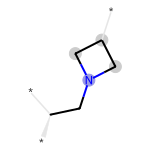
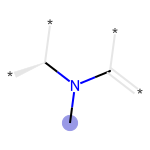
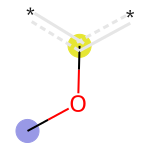
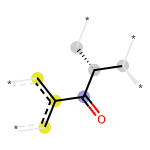
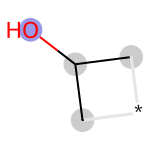
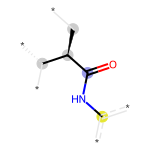
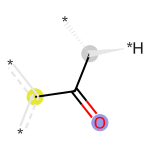

In [36]:
# display the atom envs and examples for radius 1
display_all_pictures(interesting_fingerprints,columns=[('Visualize atom env',150),('Example atom env',400)])


# End